# 🤗 HuggingFace Neural Network Notebook

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

### 2.0
1. Sliding window technique
2. wandb logging
3. Threshold

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true
env: WANDB_NOTEBOOK_NAME="neural_network.ipynb"


### Import Libraries

In [2]:
import gc
import os
import random
import time
from typing import Tuple, List
import warnings
import pickle as pkl

from dotenv import load_dotenv
import wandb
from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../../")
warnings.simplefilter('ignore')
load_dotenv()

True

In [4]:
from lib.criterion.metrics import log_metrics
from lib.utils.find_threshold import find_thresholds

### Paths

In [5]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir"
    model_path: str = os.path.join(output_path, "{model_name}_fold_{fold}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    oof_path: str = os.path.join(output_path, "valid_df_fold_{fold}.csv")
    threshold_path: str = os.path.join(output_path, "threshold.pkl")
    logging_path: str = os.path.join(output_path, "logging")

### Configurations

In [6]:
DEBUG = False
DO_SLIDING_WINDOW = True
DO_REGRESSION = True

In [7]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-large"
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    lr: float = 2e-5
    lr_scheduler_type: str = "cosine"
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 3
    num_workers: int = 6
    seed: int = 20
    stride_length: int = 384
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0
    train_folds: List[int] = list(range(num_folds))

In [8]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

In [9]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [10]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

### WandB setup

In [11]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = CFG.backbone_model.split("/")[-1]
type = "R" if DO_REGRESSION else "C"
WANDB_NAME = f"{model_name}-{CFG.max_length}-{type}"

In [12]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "neural_network.ipynb".
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Data Preparation

### Tokenizer

In [13]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir/deberta-v3-large_tokenizer/tokenizer_config.json',
 'output/model_dir/deberta-v3-large_tokenizer/special_tokens_map.json',
 'output/model_dir/deberta-v3-large_tokenizer/spm.model',
 'output/model_dir/deberta-v3-large_tokenizer/added_tokens.json',
 'output/model_dir/deberta-v3-large_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `label` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [15]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if DO_REGRESSION:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### Train-Valid Splitting

In [16]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["label"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head(3)

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,1.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,5.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,4,2.0,6.0


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [17]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [18]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [19]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [20]:
if DO_SLIDING_WINDOW:
    data = sliding_window(data, tokenizer)
    data.head(3)

100%|██████████| 17307/17307 [00:32<00:00, 540.05it/s]


## Metrics

### QWK Score Calculation

In [21]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [22]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

In [23]:
if DO_REGRESSION:
    compute_metrics = compute_metrics_for_regression
else:
    compute_metrics = compute_metrics_for_classification

### WandB Metric Logging

In [24]:
def plot_wandb_bar(data, label, value, id, title):
    table = wandb.Table(data=data, columns=[label, value])
    wandb.log({id: wandb.plot.bar(table, label, value, title=title)})

In [25]:
def plot_metrics(prefix, precision_data, recall_data, f1_data):
    plot_wandb_bar(
        f1_data,
        "score",
        "F1 Score",
        f"{prefix}/F1 Score",
        f"F1 score for {prefix}",
    )
    plot_wandb_bar(
        recall_data,
        "score",
        "Recall",
        f"{prefix}/Recall",
        f"Recall for {prefix}",
    )
    plot_wandb_bar(
        precision_data,
        "score",
        "Precision",
        f"{prefix}/Precision",
        f"Precision for {prefix}",
    )

In [26]:
def calcluate_metrics(df):
    precision_data = [None for _ in range(CFG.num_labels)]
    recall_data = [None for _ in range(CFG.num_labels)]
    f1_data = [None for _ in range(CFG.num_labels)]

    for label in range(CFG.num_labels):
        tp = df.loc[(df.label == label) & (df.label == df.pred_score), "label"].count()
        fp = df.loc[(df.label != label) & (df.pred_score == label), "label"].count()
        tn = df.loc[(df.label != label) & (df.pred_score != label), "label"].count()
        fn = df.loc[(df.label == label) & (df.pred_score != label), "label"].count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        precision_data[label] = (label, precision)
        recall_data[label] = (label, recall)
        f1_data[label] = (label, f1)

    return precision_data, recall_data, f1_data

In [27]:
def log_metrics(df, prefix):
    wandb.log(
        {
            f"{prefix}/conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=df["label"].astype(pd.Int32Dtype()),
                preds=df["pred_score"].astype(pd.Int32Dtype()),
                class_names=list(range(CFG.num_labels)),
            )
        }
    )

    precision_data, recall_data, f1_data = calcluate_metrics(df)
    plot_metrics(prefix, precision_data, recall_data, f1_data)

## Training

### Training Arguments

In [28]:
training_args = TrainingArguments(
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    evaluation_strategy="epoch",
    fp16=True,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    logging_dir=Paths.logging_path,
    lr_scheduler_type=CFG.lr_scheduler_type,
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="wandb",
    seed=CFG.seed,
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

### Utility Functions

In [29]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold].reset_index(drop=True)
    valid = data[data["fold"] == fold].reset_index(drop=True)
    return train, valid

In [30]:
def tokenize_data(train: pd.DataFrame, valid: pd.DataFrame) -> Tuple[Dataset, Dataset]:
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenized_train, tokenized_valid

In [31]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if DO_REGRESSION:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [32]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [33]:
def post_process_predictions(predictions0):
    if DO_REGRESSION:
        predictions = predictions0.clip(0, 5).round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions

In [34]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(CFG.num_labels)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(CFG.num_labels)]
    )
    draw_cm.plot()
    plt.show()

In [35]:
def save_model_and_tokenizer(fold: int, trainer: Trainer):
    trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME, fold=fold))

In [36]:
def save_oof_predictions(fold, valid, logits, y_pred):
    if DO_REGRESSION:
        valid["logit"] = logits
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = logits

    valid["pred_score"] = y_pred
    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)
    return valid

### CV Training Fold Loop

In [37]:
scores = []

for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    y_true = valid["label"].values
    logits = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(logits)

    save_model_and_tokenizer(fold, trainer)

    oof_df = save_oof_predictions(fold, valid, logits, y_pred)
    log_metrics(oof_df, f"Fold {fold}")
    
    score = compute_metrics((oof_df["pred_score"], oof_df["label"]))
    scores.append((fold, score))

    del (
        train,
        valid,
        tokenized_train,
        tokenized_valid,
        backbone_model,
        data_collator,
        trainer,
        y_pred,
        y_true,
        logits,
    )
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)

Map:   0%|          | 0/18959 [00:00<?, ? examples/s]

Map:   0%|          | 0/3788 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1779 [00:00<?, ?it/s]

{'loss': 5.6893, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.6903, 'grad_norm': 58.03953552246094, 'learning_rate': 1.9965575769494185e-05, 'epoch': 0.08}
{'loss': 0.5128, 'grad_norm': 5.967362403869629, 'learning_rate': 1.985364784018266e-05, 'epoch': 0.17}
{'loss': 0.4462, 'grad_norm': 18.39863395690918, 'learning_rate': 1.9664947934767614e-05, 'epoch': 0.25}
{'loss': 0.4486, 'grad_norm': 13.0922212600708, 'learning_rate': 1.940094625645341e-05, 'epoch': 0.34}
{'loss': 0.4299, 'grad_norm': 7.379660129547119, 'learning_rate': 1.906369970141368e-05, 'epoch': 0.42}
{'loss': 0.4462, 'grad_norm': 25.678030014038086, 'learning_rate': 1.8655835833052808e-05, 'epoch': 0.51}
{'loss': 0.3895, 'grad_norm': 2.3169610500335693, 'learning_rate': 1.8180532410071236e-05, 'epoch': 0.59}
{'loss': 0.3686, 'grad_norm': 7.118103981018066, 'learning_rate': 1.7641492627836093e-05, 'epoch': 0.67}
{'loss': 0.3715, 'grad_norm': 3.824005603790283, 'learning_rate': 1.7042916265957107e-05,

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.5164181590080261, 'eval_qwk': 0.7479556078832483, 'eval_runtime': 61.9793, 'eval_samples_per_second': 61.117, 'eval_steps_per_second': 1.92, 'epoch': 1.0}
{'loss': 0.3074, 'grad_norm': 3.76750111579895, 'learning_rate': 1.4938702096993057e-05, 'epoch': 1.01}
{'loss': 0.2568, 'grad_norm': 4.753366947174072, 'learning_rate': 1.4152689760077191e-05, 'epoch': 1.1}
{'loss': 0.2814, 'grad_norm': 14.482589721679688, 'learning_rate': 1.3334322887643436e-05, 'epoch': 1.18}
{'loss': 0.2451, 'grad_norm': 9.688562393188477, 'learning_rate': 1.2489977559189796e-05, 'epoch': 1.26}
{'loss': 0.2235, 'grad_norm': 5.344655513763428, 'learning_rate': 1.1626232258180528e-05, 'epoch': 1.35}
{'loss': 0.2251, 'grad_norm': 3.5451507568359375, 'learning_rate': 1.074981661760882e-05, 'epoch': 1.43}
{'loss': 0.2363, 'grad_norm': 2.837968349456787, 'learning_rate': 9.867558987919704e-06, 'epoch': 1.52}
{'loss': 0.2086, 'grad_norm': 9.206805229187012, 'learning_rate': 8.98633323580319e-06, 'epoch':

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.5070301294326782, 'eval_qwk': 0.7749410816849163, 'eval_runtime': 61.9734, 'eval_samples_per_second': 61.123, 'eval_steps_per_second': 1.92, 'epoch': 2.0}
{'loss': 0.1675, 'grad_norm': 2.245270252227783, 'learning_rate': 4.832726303773042e-06, 'epoch': 2.02}
{'loss': 0.1106, 'grad_norm': 3.4544034004211426, 'learning_rate': 4.0978866305482965e-06, 'epoch': 2.11}
{'loss': 0.112, 'grad_norm': 2.2039101123809814, 'learning_rate': 3.409031643797942e-06, 'epoch': 2.19}
{'loss': 0.098, 'grad_norm': 1.9011200666427612, 'learning_rate': 2.771528366926837e-06, 'epoch': 2.28}
{'loss': 0.096, 'grad_norm': 1.6561259031295776, 'learning_rate': 2.1903437306728902e-06, 'epoch': 2.36}
{'loss': 0.0971, 'grad_norm': 2.1694867610931396, 'learning_rate': 1.6700058746377879e-06, 'epoch': 2.45}
{'loss': 0.0965, 'grad_norm': 4.055523872375488, 'learning_rate': 1.2145688675377243e-06, 'epoch': 2.53}
{'loss': 0.0921, 'grad_norm': 3.267329216003418, 'learning_rate': 8.275811210465101e-07, 'epoch

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.48601868748664856, 'eval_qwk': 0.7749243911438951, 'eval_runtime': 62.045, 'eval_samples_per_second': 61.052, 'eval_steps_per_second': 1.918, 'epoch': 3.0}
{'train_runtime': 3609.4363, 'train_samples_per_second': 15.758, 'train_steps_per_second': 0.493, 'train_loss': 0.28078243811523196, 'epoch': 3.0}


  0%|          | 0/119 [00:00<?, ?it/s]

Map:   0%|          | 0/19638 [00:00<?, ? examples/s]

Map:   0%|          | 0/3109 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1842 [00:00<?, ?it/s]

{'loss': 5.4782, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.4156, 'grad_norm': 10.940593719482422, 'learning_rate': 1.9967889013361734e-05, 'epoch': 0.08}
{'loss': 0.5048, 'grad_norm': 12.006794929504395, 'learning_rate': 1.9863465246086695e-05, 'epoch': 0.16}
{'loss': 0.4491, 'grad_norm': 3.6746811866760254, 'learning_rate': 1.9687356721613084e-05, 'epoch': 0.24}
{'loss': 0.4472, 'grad_norm': 4.595831871032715, 'learning_rate': 1.944084334477175e-05, 'epoch': 0.33}
{'loss': 0.5132, 'grad_norm': 3.4765400886535645, 'learning_rate': 1.9125716702101943e-05, 'epoch': 0.41}
{'loss': 0.3617, 'grad_norm': 9.204696655273438, 'learning_rate': 1.8744267041128528e-05, 'epoch': 0.49}
{'loss': 0.373, 'grad_norm': 7.450947284698486, 'learning_rate': 1.82992666255183e-05, 'epoch': 0.57}
{'loss': 0.3335, 'grad_norm': 3.440671920776367, 'learning_rate': 1.7793949587085014e-05, 'epoch': 0.65}
{'loss': 0.3526, 'grad_norm': 5.9435133934021, 'learning_rate': 1.7231988421072957e-05,

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.4669998586177826, 'eval_qwk': 0.6958731504007124, 'eval_runtime': 51.0263, 'eval_samples_per_second': 60.929, 'eval_steps_per_second': 1.921, 'epoch': 1.0}
{'loss': 0.2727, 'grad_norm': 9.174480438232422, 'learning_rate': 1.4504918404185642e-05, 'epoch': 1.06}
{'loss': 0.262, 'grad_norm': 9.915054321289062, 'learning_rate': 1.3728137058762715e-05, 'epoch': 1.14}
{'loss': 0.2591, 'grad_norm': 3.8824350833892822, 'learning_rate': 1.2924260712425536e-05, 'epoch': 1.22}
{'loss': 0.2582, 'grad_norm': 4.847653388977051, 'learning_rate': 1.209913170143901e-05, 'epoch': 1.3}
{'loss': 0.2307, 'grad_norm': 2.893662929534912, 'learning_rate': 1.125874682016844e-05, 'epoch': 1.38}
{'loss': 0.2318, 'grad_norm': 11.949493408203125, 'learning_rate': 1.0409213738146207e-05, 'epoch': 1.47}
{'loss': 0.2238, 'grad_norm': 4.916473865509033, 'learning_rate': 9.556706611330435e-06, 'epoch': 1.55}
{'loss': 0.2375, 'grad_norm': 3.578916072845459, 'learning_rate': 8.707421210159935e-06, 'epoch'

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.5783936977386475, 'eval_qwk': 0.6856951533641138, 'eval_runtime': 51.1359, 'eval_samples_per_second': 60.799, 'eval_steps_per_second': 1.916, 'epoch': 2.0}
{'loss': 0.1785, 'grad_norm': 2.6372783184051514, 'learning_rate': 4.722037406107308e-06, 'epoch': 2.04}
{'loss': 0.1234, 'grad_norm': 2.304769992828369, 'learning_rate': 4.017778967137533e-06, 'epoch': 2.12}
{'loss': 0.104, 'grad_norm': 6.200413227081299, 'learning_rate': 3.3569975467965955e-06, 'epoch': 2.2}
{'loss': 0.1132, 'grad_norm': 8.174712181091309, 'learning_rate': 2.744495509618319e-06, 'epoch': 2.28}
{'loss': 0.1065, 'grad_norm': 2.0326828956604004, 'learning_rate': 2.1847243398147266e-06, 'epoch': 2.36}
{'loss': 0.1026, 'grad_norm': 1.8204716444015503, 'learning_rate': 1.6817522892012762e-06, 'epoch': 2.44}
{'loss': 0.1011, 'grad_norm': 2.600802183151245, 'learning_rate': 1.2392348103421903e-06, 'epoch': 2.52}
{'loss': 0.1064, 'grad_norm': 1.8487049341201782, 'learning_rate': 8.603879897990042e-07, 'epoc

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.47657033801078796, 'eval_qwk': 0.7292090564759764, 'eval_runtime': 51.1148, 'eval_samples_per_second': 60.824, 'eval_steps_per_second': 1.917, 'epoch': 3.0}
{'train_runtime': 3655.0763, 'train_samples_per_second': 16.118, 'train_steps_per_second': 0.504, 'train_loss': 0.272933213382021, 'epoch': 3.0}


  0%|          | 0/98 [00:00<?, ?it/s]

Map:   0%|          | 0/18892 [00:00<?, ? examples/s]

Map:   0%|          | 0/3855 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1773 [00:00<?, ?it/s]

{'loss': 5.844, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.467, 'grad_norm': 6.300933837890625, 'learning_rate': 1.9965342520450313e-05, 'epoch': 0.08}
{'loss': 0.4971, 'grad_norm': 17.488876342773438, 'learning_rate': 1.9852658068758722e-05, 'epoch': 0.17}
{'loss': 0.5182, 'grad_norm': 11.942164421081543, 'learning_rate': 1.9662689258749555e-05, 'epoch': 0.25}
{'loss': 0.456, 'grad_norm': 31.87725067138672, 'learning_rate': 1.9396926207859085e-05, 'epoch': 0.34}
{'loss': 0.4614, 'grad_norm': 6.900332927703857, 'learning_rate': 1.905745356438316e-05, 'epoch': 0.42}
{'loss': 0.393, 'grad_norm': 8.530701637268066, 'learning_rate': 1.8646934155473025e-05, 'epoch': 0.51}
{'loss': 0.3933, 'grad_norm': 9.954643249511719, 'learning_rate': 1.8168588099889838e-05, 'epoch': 0.59}
{'loss': 0.3651, 'grad_norm': 4.662531852722168, 'learning_rate': 1.7626167549357682e-05, 'epoch': 0.68}
{'loss': 0.3828, 'grad_norm': 13.151227951049805, 'learning_rate': 1.702392725664415e-05, 

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.5589443445205688, 'eval_qwk': 0.718245156929185, 'eval_runtime': 63.0274, 'eval_samples_per_second': 61.164, 'eval_steps_per_second': 1.92, 'epoch': 1.0}
{'loss': 0.3207, 'grad_norm': 5.2781524658203125, 'learning_rate': 1.4907648134188304e-05, 'epoch': 1.02}
{'loss': 0.2477, 'grad_norm': 9.882737159729004, 'learning_rate': 1.4117485088028391e-05, 'epoch': 1.1}
{'loss': 0.2688, 'grad_norm': 3.164824962615967, 'learning_rate': 1.329502444352601e-05, 'epoch': 1.18}
{'loss': 0.2621, 'grad_norm': 3.633033275604248, 'learning_rate': 1.2446717591027624e-05, 'epoch': 1.27}
{'loss': 0.2569, 'grad_norm': 6.944479465484619, 'learning_rate': 1.1579218658819651e-05, 'epoch': 1.35}
{'loss': 0.2481, 'grad_norm': 7.106196403503418, 'learning_rate': 1.0699332318072964e-05, 'epoch': 1.44}
{'loss': 0.2345, 'grad_norm': 10.382003784179688, 'learning_rate': 9.813960406927318e-06, 'epoch': 1.52}
{'loss': 0.2159, 'grad_norm': 5.6795268058776855, 'learning_rate': 8.93004779239706e-06, 'epoch'

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.3342074155807495, 'eval_qwk': 0.8283973201989394, 'eval_runtime': 63.1771, 'eval_samples_per_second': 61.019, 'eval_steps_per_second': 1.915, 'epoch': 2.0}
{'loss': 0.1678, 'grad_norm': 2.0945873260498047, 'learning_rate': 4.771615468584194e-06, 'epoch': 2.03}
{'loss': 0.1125, 'grad_norm': 2.0844194889068604, 'learning_rate': 4.037893503140057e-06, 'epoch': 2.12}
{'loss': 0.112, 'grad_norm': 5.097522258758545, 'learning_rate': 3.3509383666688943e-06, 'epoch': 2.2}
{'loss': 0.0954, 'grad_norm': 4.490921497344971, 'learning_rate': 2.7161385428209773e-06, 'epoch': 2.28}
{'loss': 0.103, 'grad_norm': 2.1826589107513428, 'learning_rate': 2.13847340840039e-06, 'epoch': 2.37}
{'loss': 0.1012, 'grad_norm': 2.403494358062744, 'learning_rate': 1.6224741750786e-06, 'epoch': 2.45}
{'loss': 0.1007, 'grad_norm': 5.330417156219482, 'learning_rate': 1.1721883465202333e-06, 'epoch': 2.54}
{'loss': 0.0939, 'grad_norm': 3.441315174102783, 'learning_rate': 7.911479697197977e-07, 'epoch': 2.

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.3707546591758728, 'eval_qwk': 0.8186247934565042, 'eval_runtime': 63.2018, 'eval_samples_per_second': 60.995, 'eval_steps_per_second': 1.915, 'epoch': 3.0}
{'train_runtime': 3559.3774, 'train_samples_per_second': 15.923, 'train_steps_per_second': 0.498, 'train_loss': 0.2801905900693787, 'epoch': 3.0}


  0%|          | 0/121 [00:00<?, ?it/s]

Map:   0%|          | 0/20923 [00:00<?, ? examples/s]

Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1962 [00:00<?, ?it/s]

{'loss': 6.7708, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.6624, 'grad_norm': 26.011552810668945, 'learning_rate': 1.9971695044593195e-05, 'epoch': 0.08}
{'loss': 0.5489, 'grad_norm': 13.390632629394531, 'learning_rate': 1.9879623428956073e-05, 'epoch': 0.15}
{'loss': 0.452, 'grad_norm': 3.165879964828491, 'learning_rate': 1.972425961940401e-05, 'epoch': 0.23}
{'loss': 0.4369, 'grad_norm': 12.266727447509766, 'learning_rate': 1.9506598928808217e-05, 'epoch': 0.31}
{'loss': 0.4379, 'grad_norm': 17.860736846923828, 'learning_rate': 1.9228035764833718e-05, 'epoch': 0.38}
{'loss': 0.4077, 'grad_norm': 10.37049674987793, 'learning_rate': 1.8890354696894374e-05, 'epoch': 0.46}
{'loss': 0.4163, 'grad_norm': 4.686172962188721, 'learning_rate': 1.8495719023600417e-05, 'epoch': 0.54}
{'loss': 0.3828, 'grad_norm': 4.068937301635742, 'learning_rate': 1.8046656913939196e-05, 'epoch': 0.61}
{'loss': 0.3902, 'grad_norm': 11.202461242675781, 'learning_rate': 1.754604521097351e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.36529606580734253, 'eval_qwk': 0.6677301315816371, 'eval_runtime': 29.8772, 'eval_samples_per_second': 61.05, 'eval_steps_per_second': 1.908, 'epoch': 1.0}
{'loss': 0.2653, 'grad_norm': 6.254622936248779, 'learning_rate': 1.439234444277354e-05, 'epoch': 1.07}
{'loss': 0.2439, 'grad_norm': 5.741459846496582, 'learning_rate': 1.3659797382339162e-05, 'epoch': 1.15}
{'loss': 0.2772, 'grad_norm': 9.296158790588379, 'learning_rate': 1.2903804427708703e-05, 'epoch': 1.22}
{'loss': 0.2495, 'grad_norm': 6.485424518585205, 'learning_rate': 1.2129208724273984e-05, 'epoch': 1.3}
{'loss': 0.2548, 'grad_norm': 3.6773760318756104, 'learning_rate': 1.1340972592898745e-05, 'epoch': 1.38}
{'loss': 0.2478, 'grad_norm': 1.7896900177001953, 'learning_rate': 1.0544145739620519e-05, 'epoch': 1.45}
{'loss': 0.208, 'grad_norm': 3.5288047790527344, 'learning_rate': 9.743832905533644e-06, 'epoch': 1.53}
{'loss': 0.2055, 'grad_norm': 3.2797553539276123, 'learning_rate': 8.945161164099156e-06, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5657201409339905, 'eval_qwk': 0.5750901327882553, 'eval_runtime': 30.0122, 'eval_samples_per_second': 60.775, 'eval_steps_per_second': 1.899, 'epoch': 2.0}
{'loss': 0.1221, 'grad_norm': 5.061391353607178, 'learning_rate': 4.469285771467181e-06, 'epoch': 2.06}
{'loss': 0.1192, 'grad_norm': 8.506162643432617, 'learning_rate': 3.820698842530725e-06, 'epoch': 2.14}
{'loss': 0.1064, 'grad_norm': 2.2197279930114746, 'learning_rate': 3.211698597229508e-06, 'epoch': 2.22}
{'loss': 0.1057, 'grad_norm': 6.292351722717285, 'learning_rate': 2.6461864961704975e-06, 'epoch': 2.29}
{'loss': 0.1048, 'grad_norm': 3.0574495792388916, 'learning_rate': 2.1277854002672683e-06, 'epoch': 2.37}
{'loss': 0.0979, 'grad_norm': 4.8517255783081055, 'learning_rate': 1.6598163614732154e-06, 'epoch': 2.45}
{'loss': 0.0988, 'grad_norm': 3.5179660320281982, 'learning_rate': 1.2452773470046543e-06, 'epoch': 2.52}
{'loss': 0.0953, 'grad_norm': 2.0717008113861084, 'learning_rate': 8.868240333534816e-07, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48968425393104553, 'eval_qwk': 0.6097277848347982, 'eval_runtime': 29.9936, 'eval_samples_per_second': 60.813, 'eval_steps_per_second': 1.9, 'epoch': 3.0}
{'train_runtime': 3822.406, 'train_samples_per_second': 16.421, 'train_steps_per_second': 0.513, 'train_loss': 0.2786243839852064, 'epoch': 3.0}


  0%|          | 0/57 [00:00<?, ?it/s]

Map:   0%|          | 0/17996 [00:00<?, ? examples/s]

Map:   0%|          | 0/4751 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1689 [00:00<?, ?it/s]

{'loss': 4.8087, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.4867, 'grad_norm': 24.177976608276367, 'learning_rate': 1.9961811767580646e-05, 'epoch': 0.09}
{'loss': 0.5834, 'grad_norm': 9.563528060913086, 'learning_rate': 1.98376787096968e-05, 'epoch': 0.18}
{'loss': 0.546, 'grad_norm': 17.0860652923584, 'learning_rate': 1.9628518028695307e-05, 'epoch': 0.27}
{'loss': 0.4583, 'grad_norm': 9.945731163024902, 'learning_rate': 1.9336137512376532e-05, 'epoch': 0.36}
{'loss': 0.4386, 'grad_norm': 5.0173821449279785, 'learning_rate': 1.8963064222365694e-05, 'epoch': 0.44}
{'loss': 0.4075, 'grad_norm': 13.197673797607422, 'learning_rate': 1.851252265257384e-05, 'epoch': 0.53}
{'loss': 0.4389, 'grad_norm': 2.337104082107544, 'learning_rate': 1.7988406859711457e-05, 'epoch': 0.62}
{'loss': 0.4069, 'grad_norm': 7.807412624359131, 'learning_rate': 1.7395246806732266e-05, 'epoch': 0.71}
{'loss': 0.3622, 'grad_norm': 12.673369407653809, 'learning_rate': 1.6738169210102765e-05

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.40626776218414307, 'eval_qwk': 0.7388006678270538, 'eval_runtime': 77.9924, 'eval_samples_per_second': 60.916, 'eval_steps_per_second': 1.91, 'epoch': 1.0}
{'loss': 0.2937, 'grad_norm': 4.368807315826416, 'learning_rate': 1.4442686105726066e-05, 'epoch': 1.07}
{'loss': 0.2803, 'grad_norm': 5.719829082489014, 'learning_rate': 1.3591492438328185e-05, 'epoch': 1.15}
{'loss': 0.2707, 'grad_norm': 4.684267997741699, 'learning_rate': 1.2709257295142421e-05, 'epoch': 1.24}
{'loss': 0.2732, 'grad_norm': 3.292847156524658, 'learning_rate': 1.180360588527242e-05, 'epoch': 1.33}
{'loss': 0.2391, 'grad_norm': 8.073027610778809, 'learning_rate': 1.0882365805962083e-05, 'epoch': 1.42}
{'loss': 0.2479, 'grad_norm': 8.9955415725708, 'learning_rate': 9.953499388222203e-06, 'epoch': 1.51}
{'loss': 0.2224, 'grad_norm': 4.3476128578186035, 'learning_rate': 9.025034877945422e-06, 'epoch': 1.6}
{'loss': 0.2202, 'grad_norm': 9.467677116394043, 'learning_rate': 8.104997047315048e-06, 'epoch': 

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.3507189154624939, 'eval_qwk': 0.7547250452964881, 'eval_runtime': 77.8228, 'eval_samples_per_second': 61.049, 'eval_steps_per_second': 1.915, 'epoch': 2.0}
{'loss': 0.1719, 'grad_norm': 4.205661296844482, 'learning_rate': 4.665624672785566e-06, 'epoch': 2.04}
{'loss': 0.1302, 'grad_norm': 2.079169511795044, 'learning_rate': 3.903166938389664e-06, 'epoch': 2.13}
{'loss': 0.1196, 'grad_norm': 2.928260326385498, 'learning_rate': 3.193404482938256e-06, 'epoch': 2.22}
{'loss': 0.1186, 'grad_norm': 2.5484304428100586, 'learning_rate': 2.542471824171353e-06, 'epoch': 2.31}
{'loss': 0.1253, 'grad_norm': 5.433182239532471, 'learning_rate': 1.955995010511338e-06, 'epoch': 2.4}
{'loss': 0.1178, 'grad_norm': 5.352368354797363, 'learning_rate': 1.4390429948027429e-06, 'epoch': 2.49}
{'loss': 0.1064, 'grad_norm': 2.7855916023254395, 'learning_rate': 9.960838230611636e-07, 'epoch': 2.58}
{'loss': 0.1048, 'grad_norm': 2.9111335277557373, 'learning_rate': 6.309460168944692e-07, 'epoch':

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.328933984041214, 'eval_qwk': 0.757538140330935, 'eval_runtime': 77.9733, 'eval_samples_per_second': 60.931, 'eval_steps_per_second': 1.911, 'epoch': 3.0}
{'train_runtime': 3447.9051, 'train_samples_per_second': 15.658, 'train_steps_per_second': 0.49, 'train_loss': 0.29619951259461713, 'epoch': 3.0}


  0%|          | 0/149 [00:00<?, ?it/s]

Map:   0%|          | 0/20196 [00:00<?, ? examples/s]

Map:   0%|          | 0/2551 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1896 [00:00<?, ?it/s]

{'loss': 4.9226, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.4746, 'grad_norm': 4.9437103271484375, 'learning_rate': 1.9970966560786324e-05, 'epoch': 0.08}
{'loss': 0.5939, 'grad_norm': 13.48200798034668, 'learning_rate': 1.9873753419363336e-05, 'epoch': 0.16}
{'loss': 0.5405, 'grad_norm': 34.944244384765625, 'learning_rate': 1.970880780334909e-05, 'epoch': 0.24}
{'loss': 0.4881, 'grad_norm': 6.038815021514893, 'learning_rate': 1.9477261215047836e-05, 'epoch': 0.32}
{'loss': 0.4617, 'grad_norm': 14.134589195251465, 'learning_rate': 1.9180702029492118e-05, 'epoch': 0.4}
{'loss': 0.4686, 'grad_norm': 3.5376136302948, 'learning_rate': 1.8821164598427148e-05, 'epoch': 0.47}
{'loss': 0.3799, 'grad_norm': 3.3311026096343994, 'learning_rate': 1.84011152949615e-05, 'epoch': 0.55}
{'loss': 0.3621, 'grad_norm': 6.62144136428833, 'learning_rate': 1.7923435594615744e-05, 'epoch': 0.63}
{'loss': 0.3515, 'grad_norm': 7.989975452423096, 'learning_rate': 1.7391402308830506e-05, 

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.7192689776420593, 'eval_qwk': 0.6732605948511431, 'eval_runtime': 41.9742, 'eval_samples_per_second': 60.775, 'eval_steps_per_second': 1.906, 'epoch': 1.0}
{'loss': 0.3005, 'grad_norm': 11.169295310974121, 'learning_rate': 1.4797777278233779e-05, 'epoch': 1.03}
{'loss': 0.2745, 'grad_norm': 5.846409320831299, 'learning_rate': 1.405525320812994e-05, 'epoch': 1.11}
{'loss': 0.2209, 'grad_norm': 3.8636481761932373, 'learning_rate': 1.3284910706350249e-05, 'epoch': 1.19}
{'loss': 0.2306, 'grad_norm': 4.197505950927734, 'learning_rate': 1.2492034207467081e-05, 'epoch': 1.27}
{'loss': 0.2606, 'grad_norm': 3.7580406665802, 'learning_rate': 1.1682062725909257e-05, 'epoch': 1.34}
{'loss': 0.2281, 'grad_norm': 3.305265426635742, 'learning_rate': 1.086055254513497e-05, 'epoch': 1.42}
{'loss': 0.2377, 'grad_norm': 9.95831298828125, 'learning_rate': 1.0033139102356641e-05, 'epoch': 1.5}
{'loss': 0.2215, 'grad_norm': 2.6961777210235596, 'learning_rate': 9.205498330282857e-06, 'epoch'

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.7067822217941284, 'eval_qwk': 0.669455680725586, 'eval_runtime': 41.8482, 'eval_samples_per_second': 60.958, 'eval_steps_per_second': 1.912, 'epoch': 2.0}
{'loss': 0.1367, 'grad_norm': 10.053299903869629, 'learning_rate': 4.548052278373327e-06, 'epoch': 2.06}
{'loss': 0.1085, 'grad_norm': 3.19360613822937, 'learning_rate': 3.8730244848975766e-06, 'epoch': 2.14}
{'loss': 0.1067, 'grad_norm': 2.685800790786743, 'learning_rate': 3.2400268288753423e-06, 'epoch': 2.22}
{'loss': 0.0984, 'grad_norm': 3.0019285678863525, 'learning_rate': 2.6534015797387103e-06, 'epoch': 2.29}
{'loss': 0.0977, 'grad_norm': 2.6980204582214355, 'learning_rate': 2.1171728991305797e-06, 'epoch': 2.37}
{'loss': 0.092, 'grad_norm': 2.2783617973327637, 'learning_rate': 1.635019235756511e-06, 'epoch': 2.45}
{'loss': 0.0921, 'grad_norm': 4.2046051025390625, 'learning_rate': 1.2102480917756632e-06, 'epoch': 2.53}
{'loss': 0.093, 'grad_norm': 7.746869087219238, 'learning_rate': 8.457733338297069e-07, 'epoc

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 1.047427773475647, 'eval_qwk': 0.5767486503840434, 'eval_runtime': 41.9593, 'eval_samples_per_second': 60.797, 'eval_steps_per_second': 1.907, 'epoch': 3.0}
{'train_runtime': 3730.5959, 'train_samples_per_second': 16.241, 'train_steps_per_second': 0.508, 'train_loss': 0.27748889334594146, 'epoch': 3.0}


  0%|          | 0/80 [00:00<?, ?it/s]

Map:   0%|          | 0/19878 [00:00<?, ? examples/s]

Map:   0%|          | 0/2869 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1866 [00:00<?, ?it/s]

{'loss': 4.645, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 1.3861, 'grad_norm': 12.806761741638184, 'learning_rate': 1.9968709279239172e-05, 'epoch': 0.08}
{'loss': 0.5012, 'grad_norm': 4.298337936401367, 'learning_rate': 1.9866947048719285e-05, 'epoch': 0.16}
{'loss': 0.4593, 'grad_norm': 9.237325668334961, 'learning_rate': 1.969530644309323e-05, 'epoch': 0.24}
{'loss': 0.4227, 'grad_norm': 7.966719627380371, 'learning_rate': 1.9455003032543366e-05, 'epoch': 0.32}
{'loss': 0.4535, 'grad_norm': 5.9122796058654785, 'learning_rate': 1.9147738661802295e-05, 'epoch': 0.4}
{'loss': 0.4205, 'grad_norm': 20.281883239746094, 'learning_rate': 1.877568939757529e-05, 'epoch': 0.48}
{'loss': 0.3654, 'grad_norm': 4.9149041175842285, 'learning_rate': 1.834149011749119e-05, 'epoch': 0.56}
{'loss': 0.3939, 'grad_norm': 11.773971557617188, 'learning_rate': 1.7848215849723836e-05, 'epoch': 0.64}
{'loss': 0.3539, 'grad_norm': 7.632946014404297, 'learning_rate': 1.7299359995438046e-0

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.4817569851875305, 'eval_qwk': 0.7471435926079062, 'eval_runtime': 47.2704, 'eval_samples_per_second': 60.693, 'eval_steps_per_second': 1.904, 'epoch': 1.0}
{'loss': 0.3068, 'grad_norm': 5.27940559387207, 'learning_rate': 1.4631169844663284e-05, 'epoch': 1.05}
{'loss': 0.2343, 'grad_norm': 2.8565473556518555, 'learning_rate': 1.3869567786201562e-05, 'epoch': 1.13}
{'loss': 0.2753, 'grad_norm': 4.960285186767578, 'learning_rate': 1.3080561191369286e-05, 'epoch': 1.21}
{'loss': 0.24, 'grad_norm': 9.040861129760742, 'learning_rate': 1.2269737857336412e-05, 'epoch': 1.29}
{'loss': 0.2548, 'grad_norm': 10.287030220031738, 'learning_rate': 1.1442840088870628e-05, 'epoch': 1.37}
{'loss': 0.2272, 'grad_norm': 8.09636116027832, 'learning_rate': 1.0605724030953155e-05, 'epoch': 1.45}
{'loss': 0.2485, 'grad_norm': 6.509798049926758, 'learning_rate': 9.764318195170575e-06, 'epoch': 1.53}
{'loss': 0.2162, 'grad_norm': 3.282747745513916, 'learning_rate': 8.924581473601568e-06, 'epoch'

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.4764467775821686, 'eval_qwk': 0.7776898806435484, 'eval_runtime': 47.2861, 'eval_samples_per_second': 60.673, 'eval_steps_per_second': 1.903, 'epoch': 2.0}
{'loss': 0.1981, 'grad_norm': 3.6440341472625732, 'learning_rate': 4.956322819867059e-06, 'epoch': 2.01}
{'loss': 0.1189, 'grad_norm': 5.255641937255859, 'learning_rate': 4.248156952199895e-06, 'epoch': 2.09}
{'loss': 0.1064, 'grad_norm': 3.0407419204711914, 'learning_rate': 3.580726019468671e-06, 'epoch': 2.17}
{'loss': 0.1006, 'grad_norm': 4.093122959136963, 'learning_rate': 2.9587568119201193e-06, 'epoch': 2.25}
{'loss': 0.1023, 'grad_norm': 6.7655463218688965, 'learning_rate': 2.386654156840226e-06, 'epoch': 2.33}
{'loss': 0.0951, 'grad_norm': 2.1668663024902344, 'learning_rate': 1.8684697232744886e-06, 'epoch': 2.41}
{'loss': 0.0933, 'grad_norm': 3.4192347526550293, 'learning_rate': 1.407873327838335e-06, 'epoch': 2.49}
{'loss': 0.1019, 'grad_norm': 3.4610695838928223, 'learning_rate': 1.0081269448318065e-06, 'e

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.4670966565608978, 'eval_qwk': 0.777135117765355, 'eval_runtime': 47.1268, 'eval_samples_per_second': 60.878, 'eval_steps_per_second': 1.91, 'epoch': 3.0}
{'train_runtime': 3690.4379, 'train_samples_per_second': 16.159, 'train_steps_per_second': 0.506, 'train_loss': 0.26962046639840065, 'epoch': 3.0}


  0%|          | 0/90 [00:00<?, ?it/s]

In [38]:
oof_df["score"].describe()

count    2869.000000
mean        3.269083
std         1.223359
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: score, dtype: float64

## Overall

### Logging Metrics

In [39]:
oof_df["pred_score"]

0       2.0
1       3.0
2       2.0
3       2.0
4       2.0
       ... 
2864    4.0
2865    4.0
2866    4.0
2867    2.0
2868    3.0
Name: pred_score, Length: 2869, dtype: float32

In [49]:
log_metrics(oof_df, "Overall")

table = wandb.Table(data=scores, columns=["score", "QWK"])
wandb.log(
    {
        "Overall/QWK_all_folds": wandb.plot.bar(
            table,
            "score",
            "QWK",
            title="Fold wise QWK Scores",
        )
    }
)

score = compute_metrics((oof_df["pred_score"], oof_df["label"]))["qwk"]
print(f"Overall QWK score before thresholding: {score}")
wandb.log({"CV/qwk_score": score})

Overall QWK score before thresholding: 0.7776898806435484


### Confusion Matrix

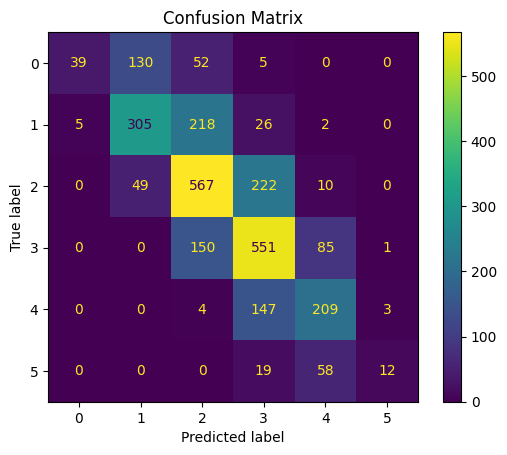

In [50]:
cm = confusion_matrix(oof_df["label"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(CFG.num_labels)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Optimal Thresholds

In [51]:
best, threshold, xs, ys = find_thresholds(oof_df["label"], oof_df["logit"], steps=500)

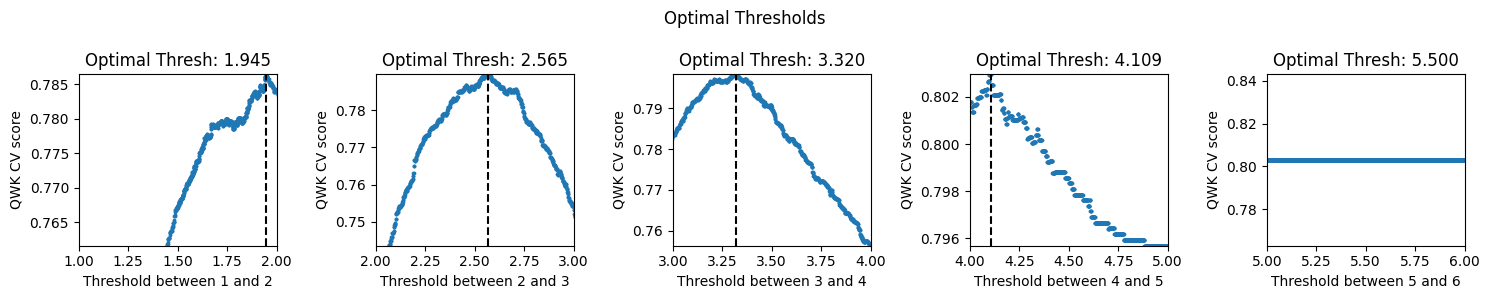

In [52]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [53]:
with open(Paths.threshold_path, "wb") as file:
    pkl.dump(threshold, file)

## Wrapping up

In [54]:
wandb.finish()

CV/qwk_score,▁
eval/loss,▃▃▃▂▃▂▃▁▁▁▃▃▂▁▁▅▅█▂▂▂
eval/qwk,▆▇▇▄▄▅▅██▄▁▂▆▆▆▄▄▁▆▇▇
eval/runtime,▆▆▆▄▄▄▆▆▆▁▁▁███▃▃▃▄▄▄
eval/samples_per_second,▇▇▆▅▃▃█▆▆▆▂▃▄▆▅▂▅▃▁▁▄
eval/steps_per_second,██▇█▆▇█▆▆▄▁▁▄▆▅▃▅▄▃▂▄
train/epoch,▂▂▄▅▇▇▂▃▄▆▇█▂▄▅▆▇▁▃▄▅▆▇▁▃▄▅▇▁▂▃▅▆▇▁▂▃▅▆█
train/global_step,▁▃▄▅▇▇▂▃▅▆█▁▃▅▆▇▁▃▄▅▇█▁▃▄▅▇▁▃▄▆▇█▂▃▅▆▇██
train/grad_norm,▇▁▄▄▁▂▂▂▂▂▁▁▄▂▄▂▂▅▂▃▃▂▁▄▅▂▂▁ ▃▁▁▅▂▁█▁▃▂▁
train/learning_rate,█▇▅▄▂▁█▇▆▃▁▁█▆▄▂▁█▇▆▄▃▁█▇▅▃▂██▆▄▃▁▁█▆▅▂▁
train/loss,▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁
